In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

# Inference and Quantization

## Paths to the dataset and trained weights

In [2]:
project_path = Path.cwd().parent
input_path = project_path / 'data' / 'SpO2' / 'SpO2_input.csv'
output_path = project_path / 'data' / 'SpO2' / 'SpO2_output.csv'
checkpoint_path = project_path / 'weights' / 'SpO2' / 'square_nn' / 'square_model_scaled_hypnogram_1000epoch.pt'

## Dataset Class

In [3]:
split_ratio = 0.8

class SpO2(Dataset):

    def __init__(self, input_path: Path, output_path: Path, train=True, scale=False):
        x = np.loadtxt(input_path, dtype=int, delimiter=',')
        y = np.loadtxt(output_path, dtype=int, delimiter=',')
        if scale:
            x = (x - np.min(x)) / (np.max(x) - np.min(x))

        split_index = int(x.shape[0] * split_ratio)
        if train:
            self.x = x[:split_index, :]
            self.y = y[:split_index]
        else:
            self.x = x[split_index:, :]
            self.y = y[split_index:]
        assert self.x.shape[0] == self.y.shape[0]
        self.x = torch.tensor(self.x, dtype=torch.float)
        self.y = torch.tensor(self.y, dtype=torch.float)
        self.y = torch.unsqueeze(self.y, dim=1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def print_info(self):
        print(f"{self.x.shape = }")
        print(f"{self.y.shape = }")
        print(f"{torch.max(self.x) = }")
        print(f"{torch.min(self.x) = }")

In [4]:
test_dataset = SpO2(input_path=input_path, 
                    output_path=output_path, 
                    train=False,
                    scale=True)
test_dataset.print_info()
batch_size = 4
test_dataloader = DataLoader(test_dataset, 
                             batch_size=batch_size)

self.x.shape = torch.Size([9217, 300])
self.y.shape = torch.Size([9217, 1])
torch.max(self.x) = tensor(1.)
torch.min(self.x) = tensor(0.)


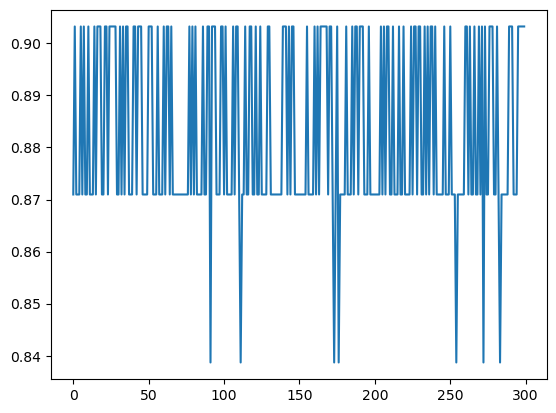

In [5]:
x = test_dataset[-2][0]
plt.plot(x)

## The Model

In [7]:
class SquareNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SquareNN, self).__init__()
        self.linear_1 = torch.nn.Linear(input_size, 128)
        self.linear_2 = torch.nn.Linear(128, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear_1(x)
        x = torch.square(x)
        x = self.linear_2(x)
        y_pred = self.sigmoid(x)
        return y_pred

### Initial Weights

In [12]:
square_nn = SquareNN(300, 1)
list(square_nn.parameters())

[Parameter containing:
 tensor([[ 0.0056,  0.0238,  0.0426,  ...,  0.0046, -0.0473, -0.0232],
         [ 0.0258,  0.0129, -0.0483,  ..., -0.0210, -0.0474,  0.0405],
         [ 0.0129,  0.0239,  0.0409,  ..., -0.0153,  0.0108, -0.0525],
         ...,
         [-0.0278, -0.0029, -0.0374,  ..., -0.0300, -0.0029,  0.0372],
         [-0.0342, -0.0528, -0.0116,  ..., -0.0179,  0.0520,  0.0111],
         [ 0.0301,  0.0205, -0.0378,  ..., -0.0228,  0.0003, -0.0222]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0190,  0.0194, -0.0124, -0.0569,  0.0296, -0.0208, -0.0087, -0.0416,
         -0.0400,  0.0372, -0.0167, -0.0245,  0.0570,  0.0063, -0.0216, -0.0262,
         -0.0404, -0.0223, -0.0138,  0.0299, -0.0518,  0.0243,  0.0253, -0.0388,
          0.0130, -0.0417,  0.0496, -0.0490,  0.0493, -0.0364,  0.0087, -0.0563,
          0.0354, -0.0211, -0.0402, -0.0430,  0.0344, -0.0457, -0.0039,  0.0058,
         -0.0520,  0.0251,  0.0180,  0.0004,  0.0250,  0.0224, -0.0334, -0.0399

### Load Trained Weights

In [13]:
square_nn = SquareNN(300, 1)
checkpoint = torch.load(checkpoint_path)
square_nn.load_state_dict(checkpoint['model_state_dict'])
list(square_nn.parameters())

[Parameter containing:
 tensor([[ 1.0139e-02,  3.0947e-02,  2.6817e-02,  ..., -6.1662e-02,
           1.7625e-03,  9.0303e-02],
         [ 2.1192e+00,  1.1557e+00,  3.2941e-01,  ...,  4.8868e-02,
          -4.9274e-01,  6.0092e-01],
         [ 3.1423e+00, -3.3778e-02, -6.5637e-01,  ...,  3.4571e-01,
           5.3613e-01,  1.1148e-01],
         ...,
         [-3.1367e+00,  2.8931e-01,  5.5360e-01,  ...,  2.6386e+00,
           9.5871e-01,  1.5863e-01],
         [ 2.4065e-01, -9.1469e-02, -8.7369e-01,  ..., -4.0021e-01,
          -1.0661e+00,  1.9891e-02],
         [-6.4772e-02,  4.4237e-01,  5.4678e-01,  ..., -6.2335e-01,
          -4.9182e-01, -1.3963e-02]], requires_grad=True),
 Parameter containing:
 tensor([ 6.3727e-03,  2.9873e+00, -5.6260e+00,  4.1148e+00, -2.2082e+00,
         -7.4740e-02,  6.2570e+00, -3.3000e-01,  1.8460e+00,  1.6248e+00,
         -1.0599e-01, -2.0954e-01,  3.2723e+00, -1.3440e+00,  5.6144e-02,
         -5.7076e-02,  1.5004e+00, -5.9462e-01, -6.8559e-01, -3.26

## Do Inference

In [14]:
device = torch.device('cpu')

def inference(model, test_loader):
    test_corrects = 0
    test_total_examples = 0    
    test_accuracies = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            # prepare data
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            # the forward pass
            y_pred = model(x)
            y_pred = y_pred.reshape(y.shape)
            # collect testing results
            test_corrects += torch.sum((y_pred.round() == y))
            test_total_examples += len(y)
    test_acc = test_corrects.item() / test_total_examples
    test_accuracies.append(test_acc)
    print(f"num_test_corrects / test_total_examples = {test_corrects.item()} / {test_total_examples}")
    print(f"testing accuracy = {test_accuracies[-1]:.4f}")

In [15]:
inference(square_nn, test_dataloader)

num_test_corrects / test_total_examples = 8031 / 9217
testing accuracy = 0.8713


## Quantization

Source: https://towardsdatascience.com/integer-only-inference-for-deep-learning-in-native-c-e57f29a20adc

In [16]:
from pytorch_quantization import calib
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor

### Define quantization using a histogram calibrator

In [23]:
quant_desc_input = QuantDescriptor(calib_method='histogram')   
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)
quant_modules.initialize()  # monkey-patch PyTorch modules with quantized versions

### Redefine the `SquareNN` Module so it contains quantizers

In [29]:
class SquareNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SquareNN, self).__init__()
        self.linear_1 = torch.nn.Linear(input_size, 128)
        self.linear_2 = torch.nn.Linear(128, output_size)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear_1(x)
        x = torch.square(x)
        x = self.linear_2(x)
        y_pred = self.sigmoid(x)
        return y_pred

square_nn_quant = SquareNN(300, 1)
square_nn_quant.load_state_dict(checkpoint['model_state_dict'])
square_nn_quant

SquareNN(
  (linear_1): QuantLinear(
    in_features=300, out_features=128, bias=True
    (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=HistogramCalibrator scale=1.0 quant)
    (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
  )
  (linear_2): QuantLinear(
    in_features=128, out_features=1, bias=True
    (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=HistogramCalibrator scale=1.0 quant)
    (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
  )
  (sigmoid): Sigmoid()
)

### Define a function to input statistics for calibration during inference and a function to compute the amax values

In [40]:

def collect_stats(model, data_loader, num_bins):
    """Feed data to the network and collect statistic"""
    model.eval()
    # Enable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.disable_quant()
                module.enable_calib()
                if isinstance(module._calibrator, calib.HistogramCalibrator):
                    module._calibrator._num_bins = num_bins
            else:
                module.disable()

    for batch, _ in data_loader:
        x = batch.float()
        model(x)

        # Disable calibrators
        for _, module in model.named_modules():
            if isinstance(module, quant_nn.TensorQuantizer):
                if module._calibrator is not None:
                    module.enable_quant()
                    module.disable_calib()
                else:
                    module.enable()


def compute_amax(model, **kwargs):
    # Load calib result
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                if isinstance(module._calibrator, calib.MaxCalibrator):
                    module.load_calib_amax()
                else:
                    module.load_calib_amax(**kwargs)

In [ ]:
with torch.no_grad():
    collect_stats(square_nn_quant, test_dataloader, 128)
    compute_amax(square_nn_quant, method="entropy")

In [64]:
def quantize_model_params(model):
    """Quantize layer weights using calculated amax
       and process scale constant for C-code

    Args:
        state_dict (Dict): pytorch model state_dict
        amax (Dict): dictionary containing amax values
    """
    scale_factor = 127 # 127 for 8 bits
    state_dict = dict()
    layer_names = ['linear_1', 'linear_2']
    
    for layer_idx, layer_name in enumerate(layer_names):
        # quantize all parameters
        weight = model.state_dict()[f'{layer_name}.weight']
        s_w = model.state_dict()[f'{layer_name}._weight_quantizer._amax'].numpy()
        s_x = model.state_dict()[f'{layer_name}._input_quantizer._amax'].numpy()

        scale = weight * (scale_factor / s_w)
        state_dict[f'{layer_name}_weight'] = torch.clamp(scale.round(), min=-127, max=127).to(int)
        state_dict[f'{layer_name}_weight'] = state_dict[f'{layer_name}_weight'].T.numpy()

        state_dict[f'{layer_name}_s_x'] = scale_factor / s_x
        state_dict[f'{layer_name}_s_x_inv'] = s_x / scale_factor
        state_dict[f'{layer_name}_s_w_inv'] = (s_w / scale_factor).squeeze()        

    return state_dict

state_dict = quantize_model_params(square_nn_quant)

In [68]:
state_dict.keys()

dict_keys(['linear_1_weight', 'linear_1_s_x', 'linear_1_s_x_inv', 'linear_1_s_w_inv', 'linear_2_weight', 'linear_2_s_x', 'linear_2_s_x_inv', 'linear_2_s_w_inv'])

In [76]:
print(state_dict['linear_1_weight'].shape)
print(state_dict['linear_2_weight'].shape)

(300, 128)
(128, 1)


In [86]:
quantized_linear_1_weight = state_dict['linear_1_weight']

print(f"{quantized_linear_1_weight.shape = }")
print(f"{quantized_linear_1_weight = }")
print(f"{quantized_linear_1_weight.max() = }")
print(f"{quantized_linear_1_weight.min() = }")


quantized_linear_1_weight.shape = (300, 128)
quantized_linear_1_weight = array([[  5,  88,  99, ..., -50,  10,  -2],
       [ 16,  48,  -1, ...,   5,  -4,  17],
       [ 14,  14, -21, ...,   9, -37,  21],
       ...,
       [-31,   2,  11, ...,  42, -17, -23],
       [  1, -20,  17, ...,  15, -45, -19],
       [ 45,  25,   4, ...,   3,   1,  -1]])
quantized_linear_1_weight.max() = 127
quantized_linear_1_weight.min() = -127


In [85]:
quantized_linear_2_weight = state_dict['linear_2_weight']
print(f"{quantized_linear_2_weight.shape = }")
print(f"{quantized_linear_2_weight = }")
print(f"{quantized_linear_2_weight.max() = }")
print(f"{quantized_linear_2_weight.min() = }")

quantized_linear_2_weight.shape = (128, 1)
quantized_linear_2_weight = array([[  -9],
       [  12],
       [  42],
       [  50],
       [ -25],
       [   0],
       [  52],
       [  13],
       [ -57],
       [ -60],
       [  -2],
       [   6],
       [  24],
       [   5],
       [   0],
       [   1],
       [  55],
       [   4],
       [   9],
       [  97],
       [   2],
       [ -11],
       [ -18],
       [   3],
       [  61],
       [   1],
       [  19],
       [ -57],
       [ -31],
       [ -20],
       [  46],
       [  28],
       [   1],
       [ -30],
       [   4],
       [   4],
       [ -47],
       [   3],
       [  -8],
       [ -10],
       [  18],
       [   7],
       [  20],
       [  13],
       [   3],
       [  74],
       [ -97],
       [   1],
       [ -28],
       [  -7],
       [  13],
       [   7],
       [   0],
       [ -21],
       [  -7],
       [  -1],
       [  17],
       [   1],
       [  13],
       [   0],
       [  19],
       [   0],

In [93]:
state_dict

{'linear_1_weight': array([[  5,  88,  99, ..., -50,  10,  -2],
       [ 16,  48,  -1, ...,   5,  -4,  17],
       [ 14,  14, -21, ...,   9, -37,  21],
       ...,
       [-31,   2,  11, ...,  42, -17, -23],
       [  1, -20,  17, ...,  15, -45, -19],
       [ 45,  25,   4, ...,   3,   1,  -1]]), 'linear_1_s_x': 140.6071470475624, 'linear_1_s_x_inv': 0.007112014012073908, 'linear_1_s_w_inv': array([0.00198565, 0.02411417, 0.0316209 , 0.03660056, 0.03377177,
       0.00226518, 0.04201226, 0.01804811, 0.0277515 , 0.03677439,
       0.002122  , 0.0140495 , 0.02574579, 0.03507228, 0.00324032,
       0.00261699, 0.06197257, 0.01316361, 0.02095175, 0.05428557,
       0.0174356 , 0.03007196, 0.01896461, 0.02098909, 0.04507471,
       0.00291833, 0.03751871, 0.04516955, 0.03721559, 0.02356489,
       0.02781525, 0.03560252, 0.01973994, 0.0358975 , 0.0197043 ,
       0.01089547, 0.04591201, 0.00661108, 0.01848545, 0.02911852,
       0.02461621, 0.03131307, 0.03295984, 0.01995438, 0.05305358,
  

In [94]:
torch.save(state_dict,
           'square_nn_quant.th')